## Imports

In [1]:
import os
import torch
import torch.nn as nn
import wandb
import numpy as np
import torchvision.transforms

from mmcv_csn import ResNet3dCSN
from csn import csn50
from i3d_head import I3DHead
from autoencoder import EncoderDecoder
from depth_head import DepthHead
from scheduler import GradualWarmupScheduler
from mmaction.datasets import build_dataset

os.chdir('../')

/home/myuser1/miniconda3/envs/wlasl/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [2]:
wandb.init(entity="cares", project="autoencoder",
           group="wlasl-100", name="depth")

wandb: Currently logged in as: sttaseen (cares). Use `wandb login --relogin` to force relogin


## Device Agnostic Code

In [2]:
# Set up device agnostic code
try:
    device = 'mps' if torch.backends.mps.is_available() else 'cpu'
except:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Dataset

In [116]:
train_cfg=dict(
    type='RawframeDataset',
    ann_file='data/wlasl/testing.txt',
    data_prefix='data/wlasl/rawframes',
    pipeline=[
        dict(
            type='SampleFrames',
            clip_len=32,
            frame_interval=2,
            num_clips=1),
        dict(type='RawFrameDecode'),
        dict(type='Resize', scale=(-1, 256)),
        dict(type='RandomResizedCrop', area_range=(0.4,1.0)),
        dict(type='Resize', scale=(224, 224), keep_ratio=False),
        dict(type='Flip', flip_ratio=0.5),
        dict(
            type='Normalize',
            mean=[123.675, 116.28, 103.53],
            std=[58.395, 57.12, 57.375],
            to_bgr=False),
        dict(type='FormatShape', input_format='NCTHW'),
        dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
        dict(type='ToTensor', keys=['imgs', 'label'])
    ])


test_cfg=dict(
        type='RawframeDataset',
        ann_file='data/wlasl/test_annotations.txt',
        data_prefix='data/wlasl/rawframes',
        pipeline=[
            dict(
                type='SampleFrames',
                clip_len=32,
                frame_interval=2,
                num_clips=1,
                test_mode=True),
            dict(type='RawFrameDecode'),
            dict(type='Resize', scale=(-1, 256)),
            dict(type='CenterCrop', crop_size=224),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_bgr=False),
            dict(type='FormatShape', input_format='NCTHW'),
            dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
            dict(type='ToTensor', keys=['imgs'])
    ])

In [4]:
work_dir = 'work_dirs/wlasl100-depth/'

os.makedirs(work_dir, exist_ok=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


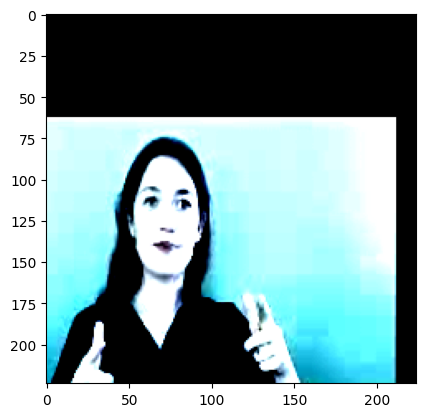

In [133]:
# Building the datasets

batch_size = 2

train_dataset = build_dataset(train_cfg)
test_dataset = build_dataset(test_cfg)

# Setting up dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    num_workers=4,
                                    pin_memory=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                    batch_size=1,
                                    shuffle=True,
                                    num_workers=4,
                                    pin_memory=True)

for x in train_loader:
    break
    
imgs = x['imgs']
img_iter = iter(imgs.squeeze().permute(1,2,3,0))
plt.imshow(next(img_iter))

## Model

In [109]:
# Create a CSN model
encoder = ResNet3dCSN(
    pretrained2d=False,
    # pretrained=None,
    pretrained='https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r50_ig65m_20210617-ce545a37.pth',
    depth=50,
    with_pool2=False,
    bottleneck_mode='ir',
    norm_eval=True,
    zero_init_residual=False,
    bn_frozen=True
)

encoder.init_weights()

depth_head = DepthHead()

decoder = I3DHead(num_classes=400,
                 in_channels=2048,
                 spatial_type='avg',
                 dropout_ratio=0.5,
                 init_std=0.01)

decoder.init_weights()

model = EncoderDecoder(encoder, decoder, depth_head)
model.load_state_dict(torch.load('work_dirs/wlasl100-depth/epoch_138.pth'))

2023-02-07 11:59:37,440 - mmcv_csn - INFO - load model from: https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r50_ig65m_20210617-ce545a37.pth
2023-02-07 11:59:37,441 - mmcv_csn - INFO - load checkpoint from http path: https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r50_ig65m_20210617-ce545a37.pth


<All keys matched successfully>

In [93]:
for x in train_loader:
    break

In [94]:
imgs = x['imgs']

In [78]:
imgs.squeeze().permute(1,0,2,3).shape

torch.Size([32, 3, 224, 224])

In [ ]:
import matplotlib.pyplot as plt

In [97]:
img_iter = iter(imgs.squeeze().permute(1,2,3,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


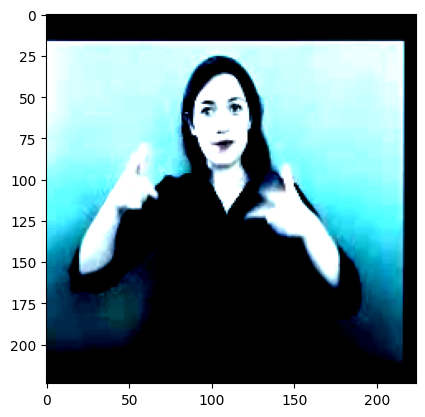

In [108]:
plt.imshow(next(img_iter))

In [80]:
imgs = imgs.reshape((-1, ) + imgs.shape[2:])

In [81]:
with torch.inference_mode():
    cls, depth = model(imgs)

In [82]:
depth.shape

torch.Size([1, 1, 32, 224, 224])

In [83]:
depth_iter = iter(depth.squeeze())

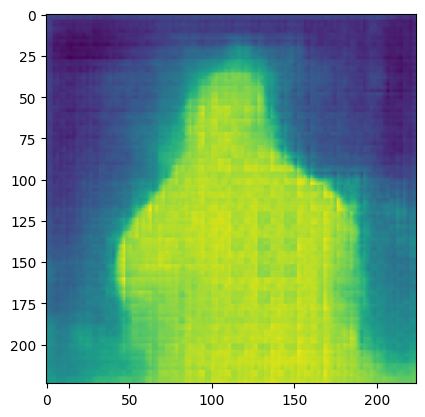

In [90]:
plt.imshow(next(depth_iter))

### Setup MiDaS

In [8]:
# Set up MiDaS depth model
# model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
# model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)
midas.to(device)
midas.eval()

Using cache found in /home/sadat/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /home/sadat/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


MidasNet_small(
  (pretrained): Module(
    (layer1): Sequential(
      (0): Conv2dSameExport(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU6(inplace=True)
          (se): Identity()
          (conv_pw): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act2): Identity()
        )
      )
      (4): Sequential(
        (0): InvertedResidual(
          (conv_pw): Conv2d(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(144,

In [9]:
def estimate_depth(images):
    with torch.no_grad():
        depth = midas(images.permute(0,2,1,3,4).reshape(-1,3,224,224))

        depth = torch.nn.functional.interpolate(
            depth.unsqueeze(1),
            size=(224,224),
            mode="bicubic",
            align_corners=False,
        ).squeeze()
        
    return depth.reshape(-1, 1, 32, 224, 224)

## Optimizer

In [10]:
# Specify optimizer
optimizer = torch.optim.SGD(
    model.parameters(), lr=0.000125, momentum=0.9, weight_decay=0.00001)

# Specify Loss
loss_cls = nn.CrossEntropyLoss()
loss_depth = nn.MSELoss()

# Specify total epochs
epochs = 100

# Specify learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=120, gamma=0.1)

scheduler_steplr = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[34, 94], gamma=0.1)
scheduler = GradualWarmupScheduler(optimizer, multiplier=1, total_epoch=16, after_scheduler=scheduler_steplr)

model.to(device)

EncoderDecoder(
  (encoder): ResNet3dCSN(
    (conv1): ConvModule(
      (conv): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
      (bn): BatchNorm3d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (activate): ReLU(inplace=True)
    )
    (maxpool): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), dilation=1, ceil_mode=False)
    (pool2): MaxPool3d(kernel_size=(2, 1, 1), stride=(2, 1, 1), padding=0, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): CSNBottleneck3d(
        (conv1): ConvModule(
          (conv): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (bn): BatchNorm3d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (activate): ReLU(inplace=True)
        )
        (conv2): Sequential(
          (0): ConvModule(
            (conv): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=64, bi

In [11]:
# x0=torch.rand((1,64,32,112,112)).to(device)
# x1=torch.rand((1,256,32,56,56)).to(device)
# x2=torch.rand((1,512,16,28,28)).to(device)
# x3=torch.rand((1,1024,8,14,14)).to(device)
# x4=torch.rand((1,2048,4,7,7)).to(device)
# x = (x0,x1,x2,x3,x4)

In [12]:
# depth_head(x).squeeze().shape

## Train Loop

In [16]:
# Setup wandb
wandb.watch(model, log_freq=10)

def top_k_accuracy(scores, labels, topk=(1, )):
    """Calculate top k accuracy score.
    Args:
        scores (list[np.ndarray]): Prediction scores for each class.
        labels (list[int]): Ground truth labels.
        topk (tuple[int]): K value for top_k_accuracy. Default: (1, ).
    Returns:
        list[float]: Top k accuracy score for each k.
    """
    res = np.zeros(len(topk))
    labels = np.array(labels)[:, np.newaxis]
    for i, k in enumerate(topk):
        max_k_preds = np.argsort(scores, axis=1)[:, -k:][:, ::-1]
        match_array = np.logical_or.reduce(max_k_preds == labels, axis=1)
        topk_acc_score = match_array.sum() / match_array.shape[0]
        res[i] = topk_acc_score

    return res


def train_one_epoch(epoch_index, interval=5):
    """Run one epoch for training.
    Args:
        epoch_index (int): Current epoch.
        interval (int): Frequency at which to print logs.
    Returns:
        last_loss (float): Loss value for the last batch.
    """
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, x in enumerate(train_loader):
        # Every data instance is an input + label pair
        images, targets = x['imgs'].to(device), x['label'].to(device)
        images = images.reshape((-1, ) + images.shape[2:])
        targets = targets.reshape(-1, )
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        cls_score, predicted_depth = model(images)
        
        # Estimate depth using MiDaS
        depth = estimate_depth(images)
        
        # Get losses
        loss_cls_score = loss_cls(cls_score, targets)
        loss_depth_score = loss_depth(predicted_depth, depth)
            
        if epoch_index<80:
            loss = 0.8 * loss_cls_score + 0.2 * loss_depth_score
        else:
            loss = loss_cls_score
        
        # Compute the loss and its gradients
        loss.backward()

        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), max_norm=40, norm_type=2.0)

        # Adjust learning weights
        optimizer.step()
        

        # Gather data and report
        running_loss += loss.item()
        if i % interval == interval-1:
            last_loss = running_loss / interval  # loss per batch
            print(
                f'Epoch [{epoch_index}][{i+1}/{len(train_loader)}], loss_cls: {loss_cls_score.item():.5}, depth_loss: {loss_depth_score.item():.5} lr: {scheduler.get_last_lr()[0]:.5e}, loss: {last_loss:.5}')
            running_loss = 0.

    return last_loss, scheduler.get_last_lr()[0]


def validate():
    """Run one epoch for validation.
    Returns:
        avg_vloss (float): Validation loss value for the last batch.
        top1_acc (float): Top-1 accuracy in decimal.
        top5_acc (float): Top-5 accuracy in decimal.
    """
    running_vloss = 0.0
    running_vacc = np.zeros(2)

    print('Evaluating top_k_accuracy...')

    with torch.inference_mode():
        for i, x in enumerate(test_loader):
            vimages, vtargets = x['imgs'].to(device), x['label'].to(device)
            vimages = vimages.reshape((-1, ) + vimages.shape[2:])
            vtargets = vtargets.reshape(-1, )
            
            # Make predictions for this batch
            cls_score, predicted_depth = model(vimages)

            # Estimate depth using MiDaS
            depth = estimate_depth(vimages)

            # Get losses
            loss_cls_score = loss_cls(cls_score, vtargets)
            
            vloss = loss_cls_score
            
            running_vloss += vloss

            running_vacc += top_k_accuracy(cls_score.detach().cpu().numpy(),
                                           vtargets.detach().cpu().numpy(), topk=(1, 5))

    avg_vloss = running_vloss / (i + 1)

    acc = running_vacc/len(test_loader)
    top1_acc = acc[0].item()
    top5_acc = acc[1].item()

    return (avg_vloss, top1_acc, top5_acc)


# Train Loop
best_vloss = 1_000_000.

for epoch in range(epochs):
    # Turn on gradient tracking and do a forward pass
    model.train(True)
    avg_loss, learning_rate = train_one_epoch(epoch+1)

    # Turn off  gradients for reporting
    model.train(False)

    avg_vloss, top1_acc, top5_acc = validate()

    print(
        f'top1_acc: {top1_acc:.4}, top5_acc: {top5_acc:.4}, train_loss: {avg_loss:.5}, val_loss: {avg_vloss:.5}')

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = work_dir + f'epoch_{epoch+1}.pth'
        print(f'Saving checkpoint at {epoch+1} epochs...')
        torch.save(model.state_dict(), model_path)

     # Adjust learning rate
    scheduler.step()

    # Track wandb
    wandb.log({'train/loss': avg_loss,
               'train/learning_rate': learning_rate,
               'val/loss': avg_vloss,
               'val/top1_accuracy': top1_acc,
               'val/top5_accuracy': top5_acc})

Epoch [1][5/890], loss_cls: 5.9938, depth_loss: 3.9582e+05 lr: 0.00000e+00, loss: 8.076e+04
Epoch [1][10/890], loss_cls: 5.9875, depth_loss: 4.1067e+05 lr: 0.00000e+00, loss: 7.8779e+04


KeyboardInterrupt: 

In [17]:
validate()

Evaluating top_k_accuracy...


(tensor(5.9921, device='cuda:0'), 0.0, 0.007751937984496124)